In [46]:
from dataclasses import dataclass
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

from c_tictactoe_py import TicTacToeEnvPy, Settings

In [47]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.network = torch.nn.Sequential(
            layer_init(torch.nn.Linear(18, 120)),
            torch.nn.LayerNorm(120),
            torch.nn.ReLU(),
            layer_init(torch.nn.Linear(120, 84)),
            torch.nn.LayerNorm(84),
            torch.nn.ReLU(),
            layer_init(torch.nn.Linear(84, 9)),
        )

    def forward(self, x):
        return self.network(x)

In [48]:
@dataclass
class Params:
    num_iterations: int
    lr: float
    gamma: float
    q_lambda: float
    num_envs: int
    num_steps: int
    device: str
    num_opt_steps: int
    batch_size: int
    num_eval_steps: int
    start_epsilon: float
    end_epsilon: float
    epsilon_end_fraction: float

In [49]:
def eval(model: MLP, env: TicTacToeEnvPy, params: Params):
    rewards = np.zeros((params.num_envs, params.num_eval_steps))
    with torch.no_grad():
        states, _ = env.reset_all()
        for i in range(params.num_eval_steps):
            state_tensor = torch.tensor(states, device=params.device, dtype=torch.float32)
            actions = model(state_tensor).max(1).indices.flatten().numpy(force=True).astype(np.int16)
            states, reward, done, _ = env.step(actions)
            rewards[:, i] = reward
        r = np.mean(rewards)
        return r

In [50]:
def get_epsilon(params: Params, iteration: int):
    slope = (params.end_epsilon - params.start_epsilon) / (params.epsilon_end_fraction * params.num_iterations)
    return max(slope * iteration + params.start_epsilon, params.end_epsilon)

[array(2.2788723, dtype=float32), array(2.4574459, dtype=float32), array(1.6530806, dtype=float32), array(1.679667, dtype=float32), array(1.4950392, dtype=float32), array(1.5212507, dtype=float32), array(1.5035293, dtype=float32), array(2.236161, dtype=float32), array(2.0183327, dtype=float32), array(1.7949058, dtype=float32), array(1.0715734, dtype=float32), array(1.2994688, dtype=float32), array(1.4578296, dtype=float32), array(1.5512791, dtype=float32), array(1.1878649, dtype=float32), array(1.4230987, dtype=float32), array(2.5001228, dtype=float32), array(2.0795999, dtype=float32), array(1.8975604, dtype=float32), array(1.7307016, dtype=float32), array(2.0804136, dtype=float32), array(1.9747487, dtype=float32), array(1.8612931, dtype=float32), array(1.7648784, dtype=float32), array(2.193218, dtype=float32), array(1.4843202, dtype=float32), array(1.6556238, dtype=float32), array(1.7413272, dtype=float32), array(1.9358927, dtype=float32), array(1.9832051, dtype=float32), array(1.4455

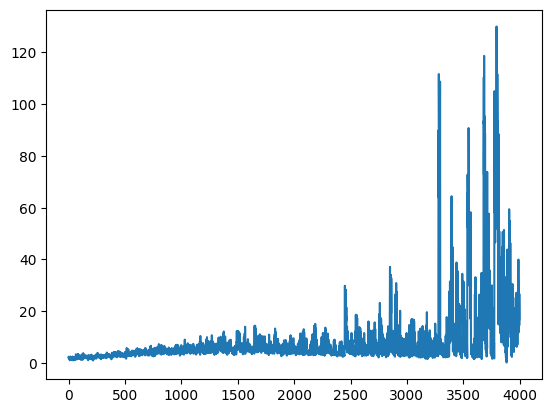

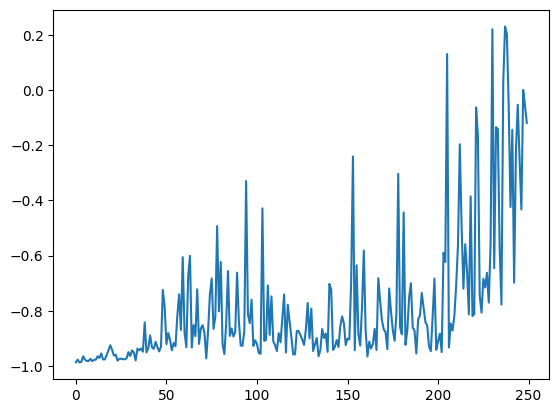

In [ ]:
params = Params(
    num_iterations=250,
    lr=2e-4,
    gamma=0.99,
    q_lambda=0.65,
    num_envs=64,
    num_steps=128,
    device="cpu",
    num_opt_steps=4,
    batch_size=32,
    num_eval_steps=150,
    start_epsilon=1.0,
    end_epsilon=0.1,
    epsilon_end_fraction=0.5,
)   
vec_env = TicTacToeEnvPy(Settings(batch_size=params.num_envs))
observations, _ = vec_env.reset_all()
q_network = MLP().to(params.device)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=params.lr, amsgrad=True)
steps_done = 0
losses = []
evals = []

obs = torch.zeros((params.num_steps + 1, params.num_envs, 18)).to(params.device)
actions = torch.zeros((params.num_steps, params.num_envs, 1)).to(params.device)
rewards = torch.zeros((params.num_steps, params.num_envs)).to(params.device)
dones = torch.zeros((params.num_steps + 1, params.num_envs)).to(params.device)
values = torch.zeros((params.num_steps, params.num_envs)).to(params.device)
returns = torch.zeros_like(rewards).to(params.device)

for iteration in range(params.num_iterations):
    q_network.eval()
    # Eval
    evals.append(eval(q_network, vec_env, params))

    epsilon = get_epsilon(params, iteration)
    
    # Rollout
    done = torch.zeros(params.num_envs, dtype=torch.float32, device=params.device)
    for step in range(params.num_steps):
        steps_done += 1
        state_tensor = torch.tensor(observations.copy(), dtype=torch.float32, device=params.device)
        obs[step] = state_tensor
        dones[step] = done

        random_actions = torch.randint(0, 9, (params.num_envs,)).to(params.device)
        with torch.no_grad():
            q_values = q_network(state_tensor)
            policy_actions = torch.argmax(q_values, dim=1)
            values[step] = q_values[torch.arange(params.num_envs), policy_actions].flatten()
        
        explore_mask = torch.rand(params.num_envs) < epsilon
        action = torch.where(explore_mask, random_actions, policy_actions)
        actions[step] = action.unsqueeze(1)
        observations, reward, done, _ = vec_env.step(action.numpy(force=True).astype(np.int16))
        rewards[step] = torch.tensor(reward, dtype=torch.float32, device=params.device)
        done = torch.tensor(done, dtype=torch.float32, device=params.device)
    # add final observation
    next_obs = torch.tensor(observations, dtype=torch.float32, device=params.device)
    obs[-1] = next_obs
    dones[-1] = done
    
    # Train
    q_network.train()
    # Q(lambda)
    with torch.no_grad():
        for t in reversed(range(params.num_steps)):
            if t == params.num_steps - 1:
                next_value, _ = torch.max(q_network(next_obs), dim=-1)
                nextnonterminal = 1.0 - done
                returns[t] = rewards[t] + params.gamma * next_value * nextnonterminal
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                next_value = values[t + 1]
                returns[t] = rewards[t] + params.gamma * (
                    params.q_lambda * returns[t + 1] + (1 - params.q_lambda) * next_value * nextnonterminal
                )

    # flatten the batch
    b_obs = obs.reshape((-1, 18))
    b_actions = actions.reshape((-1, 1))
    b_returns = returns.reshape(-1)

    # Optimize
    inds = np.arange(params.num_steps)
    for epoch in range(params.num_opt_steps):
        np.random.shuffle(inds)
        for batch_start in range(0, params.num_steps, params.batch_size):
            batch_inds = inds[batch_start : batch_start + params.batch_size]

            old_val = q_network(b_obs[batch_inds]).gather(1, b_actions[batch_inds].long()).squeeze()
            loss = torch.nn.functional.mse_loss(b_returns[batch_inds], old_val)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q_network.parameters(), max_norm=10.0)
            optimizer.step()
            losses.append(loss.detach().cpu().numpy())

plt.plot(losses)
plt.show()
plt.plot(evals)
plt.show()

In [52]:
q_network(torch.zeros(1, 18))

tensor([[ -6.2349, -12.3329, -11.4706, -11.4189, -10.8066, -10.2510, -10.7074,
         -11.0086, -11.1244]], grad_fn=<AddmmBackward0>)